# <center>Humor as a Mirror: The New Yorker Captions as Reflections of Society, Politics, and Stereotypes</center>

<br/><br/>
<center>
    <img src="data/newyorker_caption_contest_virgin/images/545.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

---

# <center>Milestone 2 : Table of content</center>

Imports, initialisations\
Path system
1. **Data preprocessing**
   - 1.1. Cleaning and preprocessing of the dataset
   - 1.2. Constructing a Funny-like metric
   - 1.3. Gathering of other datasets
   - 1.4. Executing the DataPreparation.ipynb file
   - 1.5. Tokenisation and lemmatisation of data

2. **Descriptive statistic tasks**
    - 2.1. Basic data exploration: missing data, vote distribution...

3. **Building usefull metrics**
    - 3.1. Similarity metric

4. **Narrative Flow**
   - 4.1. **Axis 1: What Is Considered Funny**
   - 4.2. **Axis 2: Professions, Politics, and Power**
   - 4.3. **Axis 3: Gender Roles**

## Path system


To be consitent in our **path system**, a **centralized file** has been created in 'src\utils\paths.py' and contains all relative paths of the project.

In [1]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH


## Imports, initialisations

In [2]:
import pandas as pd
%matplotlib inline

In case an import cannot be imported run this:

In [3]:
import importlib
import src.utils.paths as p
importlib.reload(p)

<module 'src.utils.paths' from '/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42/src/utils/paths.py'>

In [4]:
# -----------------------------------------------------------------------------
# Robust project root detection (works from notebook or script)
# -----------------------------------------------------------------------------
from pathlib import Path
import sys, os

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [5]:
import os
from src.utils.paths import DATA_PREPARATION_PY_PATH
print(DATA_PREPARATION_PY_PATH.resolve())

/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42/src/data/DataPreparation.py


In [7]:
from pathlib import Path
import sys
import os
import pickle

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


## 1 Data preprocessing

### 1.1. Cleaning and preprocessing of the dataset

[*The main preprocessing is done by this file*](src/data/DataPreparation.py)

##### Concerning the CSV files for each contests, the steps were :
- **Concatenate all 385 CSV in a list of CSV**\
After having done initial analysis and data verification, we observed 2 contests were there were unconsistency. The contest 525 does not have any image nor CSV associated, and the contest 540 does have an image, but any CSV associated. We removed those contests from the dataset. 
- **Remove redundant columns (index and rank)**\
We could import directly with rank index:
        ```python pd.read_csv(f"../newyorker_caption_contest_virgin/data/{i}.csv", index_col=['rank'])```
        but since not all files have column rank it makes sense to import as it is and later remove the redundant column. 


- **Consistency verification**\
Test if there are any NaN, Since data not contain some values, we are searching the NaN and replacing. 
        ```python data.isnull().values.any():```
        return true if there is any value that is null from data 
        ```python dataA3[i].fillna('CAPTION_NOT_FOUND', inplace = True):```
        For dataframe i fill ALL na values with 'text'

##### Concerning the JSON file, the steps were :
- **Remove non-used columns**\
Only keeping 'metadata' columns of the json, since it contains the relevant datas
- **Identifying problems**
1. Verify is contests.json size match the quantity of .CSVs.
2.  Search for missing rows. By comparing the expected index (i + dataA_offset, ti get the starting contest_id value) and the actual index (row["contest_id"]) we can verify if any row is missing. We will deal with their filling a bit later. 
3. Verify if for each row contest_id, images and data have always the same number. 
4. Verify if the order of the datas are the same as indexes (ex: (id: 13) == (contest_id - dataA_offset))\
--> It is okay, since the 525.csv and 540.csv are also missing.

- **Define an absolute indexing system**\
Since we know the starting id dataA_startID, we can substract dataA_startID from all rows and get the "normalised" indexes. 
Also dataA is already normalised exluding missing rows, so we have to normalise without missing rows to be consistent with .csv.
From the previous tests (like id vs contest_id) we know that data is sorted by contest_id and hence by id itself.

    In 'src\utils\general_utils.py' are defined two methods to obtain the value of the index in absolute indexing system ('contest_index2absolute_index') or in contest indexing system ('absolute_index2contest_index').


### 1.2 Construction of a New Funny Metric

To better identify which captions are truly funny, we designed a new *funny metric* that combines both the **proportion of votes** and the **popularity (number of votes)** of each caption.

#### 1. Weighted funny and unfunny ratios

We first compute the proportion of *funny* and *unfunny* votes relative to the total number of votes for each caption:

$$
\text{funny\_ratio} = \frac{N_{\text{funny}}}{N_{\text{total}}}
$$
$$
\text{unfunny\_ratio} = \frac{N_{\text{unfunny}}}{N_{\text{total}}}
$$

To give more importance to captions that received **more votes** (and are thus statistically more reliable), each ratio is weighted by the logarithm of the number of votes:

$$
\text{weighted\_funny} = \text{funny\_ratio} \times \log(1 + N_{\text{total}})
$$
$$
\text{weighted\_unfunny} = \text{unfunny\_ratio} \times \log(1 + N_{\text{total}})
$$

The logarithmic weighting ensures that captions with many votes are emphasized, while preventing those with extremely high vote counts from dominating the score.

#### 2. Standardization and combined score

We then normalize both weighted ratios using **z-scores** to make them comparable across captions:

$$
z_{\text{funny}} = \frac{\text{weighted\_funny} - \mu_{\text{funny}}}{\sigma_{\text{funny}}}
$$
$$
z_{\text{unfunny}} = \frac{\text{weighted\_unfunny} - \mu_{\text{unfunny}}}{\sigma_{\text{unfunny}}}
$$

Finally, the two standardized scores are combined into a **single composite score**:

$$
\text{combined\_score} = z_{\text{funny}} - z_{\text{unfunny}}
$$

A higher `combined_score` indicates captions that are **consistently rated funny** and **supported by a sufficient number of votes**.

#### 3. Ranking

All captions are then ranked according to this score:

$$
\text{rank\_funny} = \text{rank}(-\text{combined\_score})
$$

The highest `combined_score` (most funny) receives rank 1.


### 1.3. Gathering of other datasets

#### Temporal dataset augmentation :

The following webpage has **dates of some of the contests**. We add it to the **dataC** table as a new column:
"https://nextml.github.io/caption-contest-data/"

The next steps are followed, all in the same block of code so it can be re-run without issue.
1. Read the webpage, and get a "contest_id" for each image: Initially, the name of each contest is only given as "### Dashboard". Removing the "Dashboard" from the name. To fit with the previous format of dataC, reseting the index. We need to watch out, 540 exists in the new table. We need to remove it.
2. Additionally, the date here is the day the finalist was announced, not the date the cartoon came out... something to keep in mind.
3. Clean the format of the dates. Sometimes there is an "estimated" keyword, sometimes there is two dates, and sometimes, the year is missing. When there are two dates, I only keep the last date. When a year is missing from a date, look at the previous entry and take the year from there.
4. Convert the 'date' column of the dates_table dataframe to a correct date format by using pd.to_datetime.
5. The dates are prepared now and can be merged with our dataset.

#### Occupations dataset :

To recognise occupations in the captions, a comprehensive list of all possible occupations must be constructed. The difficulty with this task is that official job titles that one may find online are too specific and do not correspond to occupations people tend to mention when speaking (or writing captions). Therefore, the constructed list of occupations has to contain both generic terms but also specific occupations. To do this, the following approach was taken:
1. Five datasets of varying size and specificity were loaded. In total, these add up to around 33,000 occupations.
 - [**O*NET**](https://www.onetonline.org/find/all)  
 - [**ESCO (ESCO dataset v1.2.0)**](https://esco.ec.europa.eu/en/use-esco/download)   
 - [**Kaggle Job Description Dataset**](https://www.kaggle.com/datasets/ravindrasinghrana/job-description-dataset)  
 - [**US Labor Statistics (May 2024, all data)** ](https://www.bls.gov/oes/tables.htm)   
 - [**US Census Data (2018 Census Occupation Index)**](https://www.census.gov/topics/employment/industry-occupation/guidance/indexes.html)
2. Each dataset is cleaned with the same function, included in the cell below. The steps taken for the cleaning are:
 - Make everything lowercase
 - split jobs at "and" in a way that "sales and marketing manager" becomes "sales manager" and "marketing manager".
 - split jobs of the form "truck, ship, and boat driver" becomes "truck driver", "ship driver" and "boat driver". 
 - Other commmon cases such as this are also treated, see the function definition. There is still room for improvement in this aspect.
 - If there is a comma at the end, and it is followed by 2 or 1 words, remove the comma and the words.
 - Drop everything including "in" from the text
 - removing duplicates
3. The list is enriched by adding a synonyms column which contains the occupation and its plural form. The idea was to enrich this list by using `spacy.load('en_core_web_sm')`. This however introduced synonyms that are not actual occupations "valet <-> gentleman". 
4. Around 1000 extra words are added 
5. The constructed list is saved as a `csv` file: `final_combined_occupations.csv`.

#### Gender dataset :
**Missing**

### 1.4. Executing the DataPreparation.ipynb file

This cell executes all what's been described in section 1.1. We did not want to copy paste the code here to keep this result file clean, but for any verification about the code, please refer to ```src\data\DataPreparation.py```

In [7]:
%run {DATA_PREPARATION_PY_PATH.resolve()}

✅ Root folder detected at: C:\Users\andra\OneDrive\Desktop\MA1_2025-2026\Applied_data_analysis\project\ada-2025-project-adacore42\src\data


In [8]:
# Pickle datapreprocessed file loading
with open(STORED_DATAPREP_PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Objects extraction
dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

### 1.5. Tokenisation and lemmatisation of data

**Andras: MISSING**

In [ ]:
#load mb this pickle too

## Descriptive statistic tasks

COMMENT

- should we mention missing caption data
- mention missing metadata
- mention increase in voting number after a certain year
- mention missing dates and maybe how to fix.

What I did as basic analysis (cyrielle), maybe we can take some plots of it ?

 #### - **On 1 single cartoon (dataA[108])** 

 *1.1: avg score of the cartoon vs. number of votes*\
 *1.2: histogram of avg score of all captions proposed + hypothesis test : normal distribution?*\
 *1.3: mean caption score vs. descending rank*\
 *1.4: number of votes vs. descending rank*\
 *1.5: histogram : 'not_funny'/'somewhat_funny'/'funny' ratios among all captions, for the cartoon*\
 *1.6: Text processing : TextBlob to obtain  a DataFrame of captions caracteristics ('tags', 'nouns', 'verbs', 'polarity', 'subjectivity')*\
 &emsp;&emsp; *1.6.1: histogram polarity and subjectivity of the cartoon*\
 &emsp;&emsp; *1.6.2: Top10 of the cartoon's most cited nouns*\
 &emsp;&emsp; *1.6.3: Top10 of the cartoon's most frequent verbs* (to be improved)\


 #### - **Plots/stats on all cartoons (dataC)** 

 *2.1: General statistics*\
 *2.2: Number of captions proposed vs. cartoon contest's id \
  &emsp; + Number of votes vs. cartoon contest's id*\
 *2.3: histogram : count of cartoons vs. number of votes \
  &emsp; + histogram : count of cartoons vs. number of captions proposed*\
 *2.4: Identify the most frequent visual themes among all cartoons*\
 &emsp;&emsp; *2.4.1: Top50 most cited Locations*\
 &emsp;&emsp; *2.4.2: Top50 most cited Locations (grouped by category)*\
 &emsp;&emsp; *2.4.3: Top10 most asked questions*\
 &emsp;&emsp; *2.4.4: Top10 most used question's W-words*\
 &emsp;&emsp; *2.4.5: Top40 most used verbs* (to be improved)\


## 3. Building usefull metrics

#### Similarity metric

About the semantic embedding model used : The all-MiniLM-L6-v2 is a lightweight sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space (embeddings). It is designed for natural language understanding tasks like semantic search, clustering, and similarity comparisons, offering a balance of high performance and computational efficiency.\
Requirements:
pip install -U sentence-transformers

In [ ]:
from src.models.similarity_analysis import SimilarityModel, CaptionClustering, SimilarHumorAnalysis

# Just perform a 'naive' analysis on a random sample from a single cartoon for the moment. 
df = dataA[77].copy()
sample_size = 1000
if sample_size and len(df) > sample_size:
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)

We want to compare captions within the same contest and measure humorous clusters without ground truth. To address this, we:
- use SBERT embeddings ('all-MiniLM-L6-v2'), this model is lightweight yet robust for capturing the semantic similarity of short phrases like captions.
- perform clustering with Kmeans algorithm. The number of clusters and the name of the labels are the different types of humour, found in the litterature.
- vizualise the resulting clusters with a UMAP projection.

But one major challenge is we don't have ground truth annotated label !
- to ensure density/semantic coherence, we calculate the average intra-cluster similarity (average of cosine similarities), and compare to the average inter-cluster average. A good cluster should have: Intra-cluster average > Inter-cluster average.
- we can do a qualitative inspection by visualizations of the similarity, with heatmaps per cluster. This should show homogeneous similarity values within clusters.
- Display the 2–3 captions closest to the center of the cluster (the “prototypes”). Display the 2–3 captions furthest from the center (the “outliers” of the cluster). Manually check if it makes sense in a humorous way.


We want to see if there is "winning clusters", depicting "winning humorous types and strategies". We will try to see if the captions most similar to the finalists are grouped together, or if certain clusters concentrate more “highly rated” captions.
- Plot the distribution of the means per clusters
- For the moment NAIVE check if the humor scores are correlated with intra-cluster similarity (biases of observational studies will be later adressed with matching, bootstrapping technics), to see if there is 'better'/more funny clusters than others. Calculating the correlation between: The semantic distance between pairs of captions (1 - similarity), and the difference in humor score between these same pairs.

In [ ]:
# 1.Clustering
cluster_model = CaptionClustering(model_name='all-MiniLM-L6-v2', n_clusters=10, normalize=True)

cluster_labels, embeddings = cluster_model.cluster_captions(df)
df_clusters = cluster_model.UMAP_reduction(df, umap_n_components=3, umap_n_neighbors=15, umap_min_dist=0.1, umap_metric='cosine')

# 2 Analysis of similarity of captions within each clusters to see if the clustering with kNN is working or assigning not good clusters
sim_results = cluster_model.evaluate_intra_cluster_similarity(df, plot=False)

# 3 Analysis of humour score correlation within a similarity cluster
humor_analysis = SimilarHumorAnalysis(model_name='all-MiniLM-L6-v2')
corr_results = humor_analysis.scores_correlation_by_cluster(df_clusters, humor_col='mean')
print(corr_results.sort_values('spearman', ascending=False).head())


Limitations of this similarity metric, that has to be adressed for milestone 3:
- SBERT embeddings don't capture all humor, they "only" capture semantic proximity, not humorous style (e.g., irony, absurdity, subversion, etc.). --> Two captions that are very funny for the same reason (e.g., puns) can be very far apart semantically.

- Intra-cluster similarity isn't always enough: a cluster can be "compact" (high average similarity) but thematically irrelevant (e.g., very banal or repetitive captions).

##### From those diverse steps, statistic results and metric tools, we can now dive into our data story, yay !

<center>
    <img src="data/newyorker_caption_contest_virgin/images/612.jpg" alt="New Yorker Cartoon" style="width:350px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

## 4 Narrative Flow

### 4.1. Axis 1: What Is Considered Funny

**KATIA**

Total votes: not_funny         210747483
somewhat_funny     57140251
funny              23212253
dtype: int64


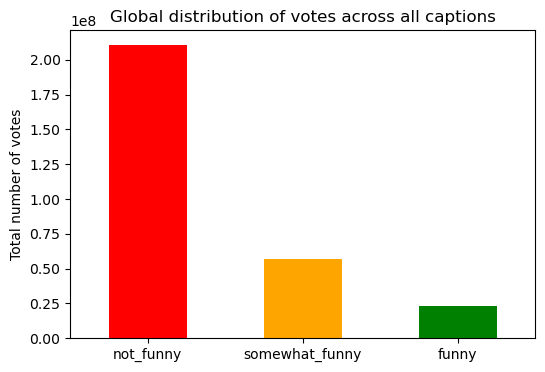

In [11]:
# Data merging to assess all captions together

for i, df in enumerate(dataA):
    df['source_df'] = i  # i  allow to keep the informatio of which images the caption is related to

dataA_merged = pd.concat(dataA, ignore_index=True)

from src.utils.function_axis_1 import plot_global_vote_distribution
plot_global_vote_distribution(dataA_merged)


From the above figure, we can clearly see that the number of votes for not_funny are way higher than for other possibility. This mean that computing the mean would be biased toword 1 as this distribution is skewed. This observation lead to the creation of a new metric for funniness that would be more resilient to the higher number of negative values With this metric, we focus solely on what people find genuinely funny, without taking into account the "somewhat funny" votes, so as not to dilute the assessment.

In [17]:
from src.utils.function_axis_1 import compute_funny_ranking
from IPython.display import display, Markdown

dataA_merged = compute_funny_ranking(dataA_merged)

Mean_best = dataA_merged.sort_values(["mean"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Mean Score"))
display(Mean_best)

Funny_score_best = dataA_merged.sort_values(["funny_score"],ascending=False).head(5)
display(Markdown("### Top 5 Captions by Funny Score"))
display(Funny_score_best)



### Top 5 Captions by Mean Score

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,funny_score,rank_funny_overall
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,88,38.599534,1.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,178,27.944338,4.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,43,31.574538,3.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,153,33.593560,2.0
29909,Who'd have thought they'd get you for tax evas...,2.391304,0.174898,23,5,4,14,7,13.971382,438.0


### Top 5 Captions by Funny Score

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,source_df,funny_score,rank_funny_overall
452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,88,38.599534,1.0
862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,153,33.593560,2.0
213623,I'll never let go.,2.634196,0.019615,1468,244,49,1175,43,31.574538,3.0
983727,3 ..2.. 1..,2.671296,0.034164,432,61,20,351,178,27.944338,4.0
1041265,Looks like you're already familiar with the si...,2.387410,0.005740,14726,1941,5211,7574,188,27.179467,5.0


From the example above, we can see that the new metric changes the order of the top funny captions and provides a more logical ranking. For instance, the second caption becomes "Lunch on me," which received 15,232 funny votes but had a lower mean than other captions with fewer voters. 

Regarding the worst captions, our metric also outperforms the mean. Using the mean, all low-scoring captions received a score of 1, which failed to distinguish the very worst captions from the others. With the new metric, captions with more voters carry greater weight, so the lowest-ranked captions are those that were overwhelmingly voted as not funny.

### 4.2. Axis 1: Professions, Politics, and Power

**Professions in Humor:**  
Which jobs are depicted most often? Which are ridiculed vs. admired? What stereotypes are recurrent (e.g., lawyers as tricksters, doctors as saviors)?  

**Politics in Humor:**  
Do captions reflect partisan leanings (Democrat vs. Republican) or mock political figures more broadly? Are political jokes rated differently?  

**Interplay:**  
Professions like politicians or lawyers sit at the crossroads of both — this axis highlights how authority and social roles are viewed through humor.

### Plots / Stats

- **Bar / Word Clouds:** Frequency of professions mentioned in captions (“doctor,” “lawyer,” “politician”).  
- **Histograms / Line Plots:** Frequency of professions across time.  
- **Grouped Bar Charts:** Average “funniness” scores by profession category (healthcare, law, politics, education, etc.).  
- **Heatmaps:** Cross-tab professions × sentiment (positive / negative / neutral).  
- **Cartoon + Caption Samples:** A few annotated cartoons showing how professions are ridiculed (adds storytelling color).  

**For politics:**
- Timeline of mentions of political figures / parties.  
- Sentiment distribution around Democrats vs. Republicans.  
- Example “political joke clusters” side by side with major events (e.g., elections).  

**Statistical Tests / Methods:**
- *t-tests / z-tests* → Compare funniness scores of politicians vs. other professions.  
- *Multiple hypothesis testing (FDR/BH)* → Control for comparisons across 30+ job categories.  
- *Network graphs* → Co-occurrence of profession keywords with stereotypes (“lawyer–money,” “doctor–death”).  
- *Linear regression / lmplot* → Test if political humor ratings rise around elections.  
- *Pearsonr / Spearmanr* → Correlation between real-world political cycles and joke frequency.  

### 4.3. Gender Roles

**Amelie**

# What is the answer to ADA, the universe and everything ?

In [1]:
import random

answer = None
number_of_tries = 0
while answer != 42:
    # Generate one random number
    answer = random.randint(0, 1_000_000)
    number_of_tries += 1

print("Number of TEEEEEENTATIVES:", number_of_tries, end="\r")
print("\nThe answer to ADA, the universe and everything is:", answer)


Number of TEEEEEENTATIVES: 1584423
The answer to ADA, the universe and everything is: 42
